In [5]:
import numpy as np
import math
import prune
import os
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
os.environ["OMP_NUM_THREADS"] = "1" # remove if running on GPU

#Load model(It takes a lo of time... on my CPU)
mp = prune.ModelPruner('resnet18', 'MNIST', 'by_channel')
print(mp.baseline)

Load model: ./model_weights/resnet18_MNIST.pt...
{'loss': 0.02684426321648061, 'acc': 99.375}


In [6]:
#this is the phony generator
def generator(in_arr):
    pruned_model = mp.prune_model(in_arr)
    return mp.get_fitness_score(pruned_model)

def One_step_single_pass(decision_len, deci_arr_in, stepsize_in, tau_in, elpslon_zero):
    random_normal_i = np.random.normal(0, 1, size=(decision_len))
    random_normal = np.random.normal(0, 1, size=(1))
    
    #store input variable
    deci_arr = np.copy(deci_arr_in)
    stepsize = np.copy(stepsize_in)
    
    stepsize*=math.exp(tau_in*random_normal[0])
    for i in range(decision_len):

        if(stepsize > elpslon_zero):
            deci_arr[i] += stepsize*random_normal_i[i]
        else:
            deci_arr[i] += elpslon_zero*random_normal_i[i]

        if(deci_arr[i] <= 0.001):
            deci_arr[i] = 0.001
        elif(deci_arr[i] >= 1):
            deci_arr[i] = 0.999

    return deci_arr, stepsize


def ESXPlusX_OS(Decision_var_record, Stepsize_record, Best_score_record, Decision_arr_init, Stepsize_init
                , Target_run, child_lambda, hp_tau, hp_elpslon_zero, Best_acc_record):
    train_runs = 0
    
    decision_var_arr = np.copy(Decision_arr_init)
    stepsize = Stepsize_init
    best_score, best_acc = generator(decision_var_arr)

    
    tau_in = hp_tau/((1/math.sqrt(len(Decision_arr_init))))

    while(train_runs < Target_run):
        print(f'Training epoch: {train_runs+1}/{Target_run}')
        memorize_parent_decision_var_arr = np.copy(decision_var_arr)
        memorize_parent_stepsize = stepsize
 
        for run in range(child_lambda):
            tmp_decision_var_arr, tmp_stepsize = One_step_single_pass(len(Decision_arr_init),memorize_parent_decision_var_arr,memorize_parent_stepsize,tau_in,hp_elpslon_zero)
            tmp_score, tmp_acc = generator(tmp_decision_var_arr)


            if(tmp_score < best_score):
                best_score = tmp_score
                best_acc = tmp_acc
                decision_var_arr = np.copy(tmp_decision_var_arr)
                stepsize = tmp_stepsize
        Decision_var_record.append(decision_var_arr)
        Stepsize_record.append(float(stepsize))
        Best_score_record.append(best_score)
        Best_acc_record.append(best_acc)
        train_runs+=1

    return decision_var_arr, stepsize, best_score




In [7]:
#Hyperparameters could be change here:

HP_DECISION_INITVAL = 0.5   # Initial value for decision variable (array)
HP_STEPSIZE_INITVAL = 0.1   # Initial value for stepsize
HP_ITERATIONS = 5           # Run how many iterations/epoch
HP_CHILD_LAMBDA = 2         # Run (1+child_lambda)-EC
HP_TAU_PARAM = 0.1          # tau = HP_TAU_PARAM/((1/sqrt(N)),
HP_ELPSLON_VALUE = 0.001    # The threshold of the step size, if stepsize < elpslon, stepsize=elpslon






#auto generated parameter (Don't change)
Decision_arr = np.array([HP_DECISION_INITVAL for i in range(mp.prunable_layer_num)]) 

DV_record = [] #records the decision variable of each epoch
SZ_record = [] #records the step size of each epoch
BS_reocrd = [] #records the best solution of each run
BA_record = [] #records the acc of best solution of each run

#run EC algorithm
ans_decvar, ans_stepsize, ans_bestscore = ESXPlusX_OS(Decision_var_record=DV_record,Stepsize_record=SZ_record,Best_score_record=BS_reocrd, 
            Decision_arr_init=Decision_arr,Stepsize_init=HP_STEPSIZE_INITVAL, Best_acc_record=BA_record,
            Target_run=HP_ITERATIONS,child_lambda=HP_CHILD_LAMBDA,hp_tau=HP_TAU_PARAM,hp_elpslon_zero=HP_ELPSLON_VALUE)


print(DV_record)
print(SZ_record)
print(BS_reocrd)
print(BA_record)


Training epoch: 1/5
Training epoch: 2/5
Training epoch: 3/5
Training epoch: 4/5
Training epoch: 5/5
[array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]), array([0.47859641, 0.50896327, 0.57644303, 0.30711118, 0.51850611,
       0.46177088, 0.52972804, 0.56712739, 0.42780381, 0.32288953,
       0.53906486, 0.51889464, 0.54712112, 0.44796336, 0.47741143,
       0.65777579, 0.33014153, 0.49569816, 0.54595144, 0.47318707]), array([0.61026905, 0.4040822 , 0.39161043, 0.28729825, 0.48918216,
       0.38643675, 0.69728111, 0.889069  , 0.6500813 , 0.25107967,
       0.52786865, 0.51229475, 0.32235605, 0.39559805, 0.08199779,
       0.68573026, 0.39042715, 0.50425329, 0.62517867, 0.30952383]), array([0.61026905, 0.4040822 , 0.39161043, 0.28729825, 0.48918216,
       0.38643675, 0.69728111, 0.889069  , 0.6500813 , 0.25107967,
       0.52786865, 0.51229475, 0.32235605, 0.39559805, 0.08199779,
       0.68573026, 0.39042715, 0.50425329,

OSError: [Errno 22] Invalid argument: './image_output/VGG11OneStepEC_5runs_2022-12-15 22:39:05.png'

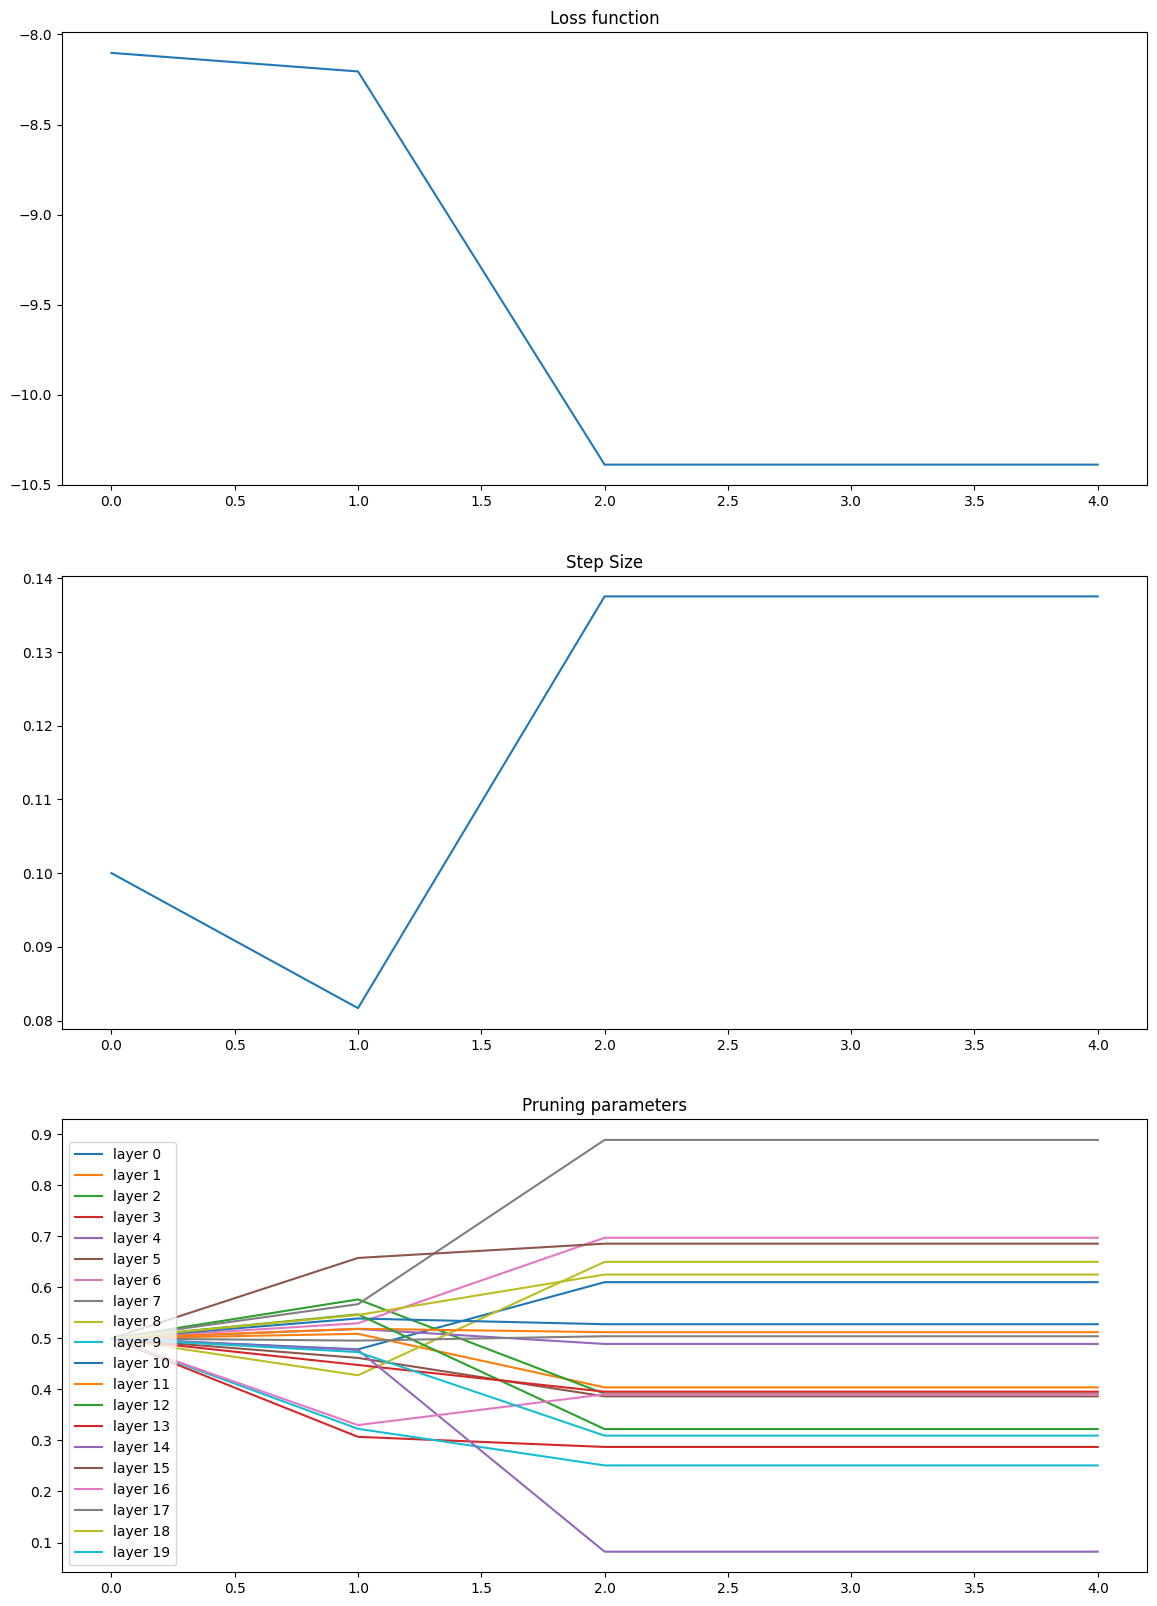

In [8]:
#visiualize the result
def plotOSResult(arr1, arr2, arr2d, model_name):
    run_num = len(arr1)
    parm_num = len(arr2d[0])
    plt.figure(figsize=(14,20))
    ax1 = plt.subplot(311)
    ax1.plot(arr1)
    ax1.set_title('Loss function')

    ax2 = plt.subplot(312)
    ax2.plot(arr2)
    ax2.set_title('Step Size')

    ax3 = plt.subplot(313)
    for line in range(parm_num):
        ax3.plot([arr2d[j][line] for j in range(run_num)], label = f'layer {line}')

    ax3.set_title('Pruning parameters')    
    ax3.legend(loc=3)   

    now=datetime.now()
    time_print=now.strftime("%Y-%m-%d %H:%M:%S")
    plt.savefig(f'./image_output/{model_name}OneStepEC_{run_num}runs_{time_print}.png',dpi = 400)
    plt.show()
    

plotOSResult(BS_reocrd,SZ_record,DV_record,"VGG11")

